In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

#### Take a look at the data

In [89]:
df = pd.read_csv("train.csv")

print df.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [90]:
df.describe()

# Drop outliers in Fare -> Commented out as results in worse accuracy
#q75, q25 = np.percentile(df["Fare"], [75 ,25])
#iqr = q75 - q25
#df = df[df["Fare"] <= iqr*3]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


###### Are there any outliers in the scaler fields that we have?
The Age field look fine, but the Fare field evidences a large number of "outliers" with three in particular being twice the size of their next largest neighbour. I investigated these data points in order to understand if they are a problem in the data, or whether they are real and researching the names of the passengers, revealed that those particular passengers had indeed been staying in the most luxurious suite on the ship, hence the expensive fare.

<IPython.core.display.Javascript object>


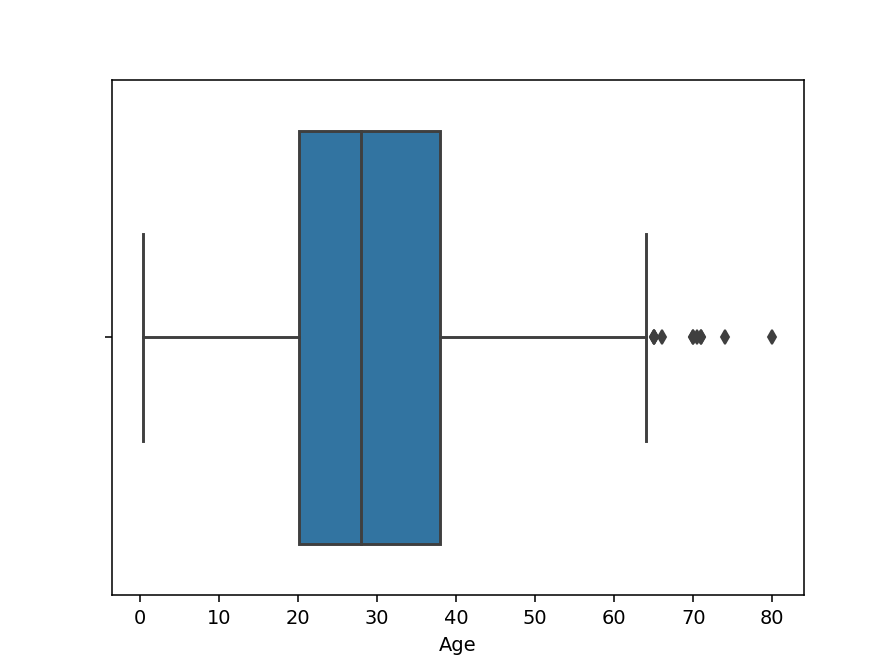

<IPython.core.display.Javascript object>


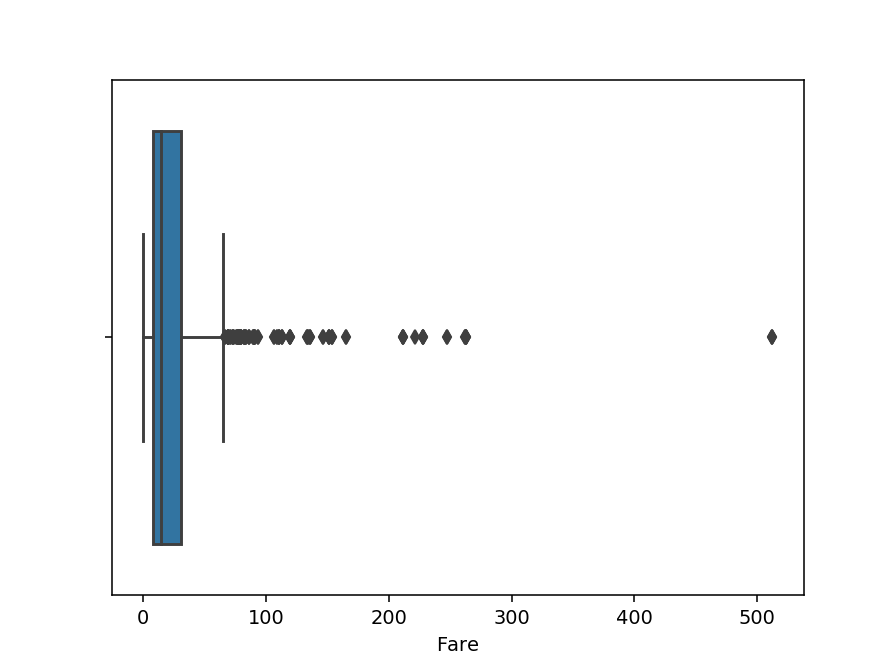

In [91]:
plt.figure()
sns.boxplot(x=df.Age)
plt.show()

plt.figure()
sns.boxplot(x=df.Fare)
plt.show()

#### Drop fields we don't need.
Dropped passenger Ids and names as those are irrelevant for the purpose of Logistic Regression. Also dropped cabin. Extracting the deck on which the passenger was housed might be relevant, however the data in this column is quite sparse and inconsistent, so it is not clear how to impute the missing values.

In [92]:
df = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### Some data cleaning
The Sex field is mapped to 0 and 1 while Age, SibSp, Parch and Fare fields are normalized ((x-min(x))/span(x)). PClass and embarked, being multi-class fields are split into |classes|-1 binary fields (one-hot encoding). Also any NaN fields are imputed to 0.

In [93]:
# Convert Sex field to 1/0
sexmap = {"male":1, "female":0}
df["Sex"] = df["Sex"].map(sexmap)

# Normalize Age
span = np.max(df["Age"]) - np.min(df["Age"])

df["Age"] = (df["Age"]-np.min(df["Age"]))/span

# Normalize SibSp
span = np.max(df["SibSp"]) - np.min(df["SibSp"])

df["SibSp"] = (df["SibSp"]-np.min(df["SibSp"]))/span

# Normalize Parch
span = np.max(df["Parch"]) - np.min(df["Parch"])

df["Parch"] = (df["Parch"]-np.min(df["Parch"]))/span

# Normalize Fare
span = np.max(df["Fare"]) - np.min(df["Fare"])

df["Fare"] = (df["Fare"]-np.min(df["Fare"]))/span

df.describe()

# Encode categorical values in 1-hot encoding
pclass_1hot = pd.get_dummies(df["Pclass"])
pclass_1hot.columns = ["pClass_"+str(pclass_1hot.columns[i]) for i in range(0,len(pclass_1hot.columns))]
df=df.join(pclass_1hot.iloc[:,0:-1])


embarked_1hot = pd.get_dummies(df["Embarked"])
embarked_1hot.columns = ["Embarked_"+str(embarked_1hot.columns[i]) for i in range(0, len(embarked_1hot.columns))]
df=df.join(embarked_1hot.iloc[:,0:-1])

df = df.drop(["Pclass", "Embarked"], axis=1)

df = df.fillna(0)

#### The new shape of the data set...

In [94]:
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,pClass_1,pClass_2,Embarked_C,Embarked_Q
0,0,1,0.271174,0.125,0.0,0.014151,0,0,0,0
1,1,0,0.472229,0.125,0.0,0.139136,1,0,1,0
2,1,0,0.321438,0.000,0.0,0.015469,0,0,0,0
3,1,0,0.434531,0.125,0.0,0.103644,1,0,0,0
4,0,1,0.434531,0.000,0.0,0.015713,0,0,0,0


This is the sigmoid function (H(X)) which is the function we want to fit in logistic regression.

    H(X) = 1/(1+exp(-(theta.X))
    
X is the vector of input features in the training set. Theta is a vector of feature weights. The goal of Logistic Regression is to tune theta so that H(X) approximates Y, the dependent feature we want to be able to predict.

In [95]:
def sigmoid(theta, X):
    power = -1 *(X.dot(theta.T))
    sig = 1/ (1+np.exp(power))

    return np.squeeze(np.asarray(sig))

Here we set up a simple plot of the sigmoid function in order to illustrate the shape

<IPython.core.display.Javascript object>


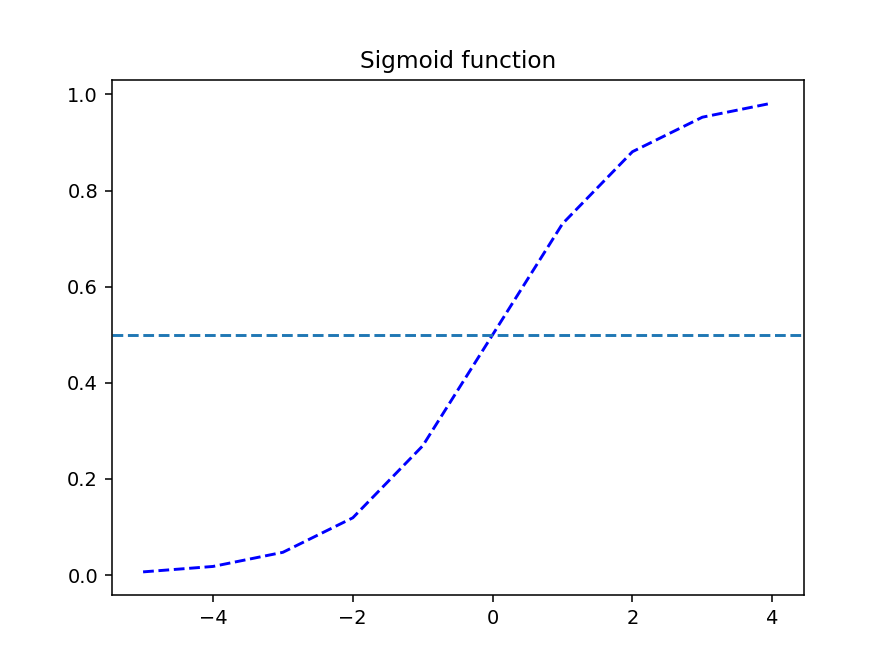

In [96]:
theta=np.array([1])
xpoints = np.matrix(np.arange(-5,5)).T
#xpoints = np.column_stack((xpoints, np.arange(-5,5)))
#ypoints = [sigmoid(theta, xpoints[i]) for i in range(0, len(xpoints))]
ypoints = sigmoid(theta, xpoints)

plt.figure()
plt.title("Sigmoid function")
plt.plot(xpoints, ypoints, "b--")
plt.axhline(y=0.5, lineStyle="--")
plt.show()


The Cost Function is the function that gives us the "distance" beetween our Hypothesis H(X) == G(theta.X) given our current set of theta and the "ground truth" of our training data. The higher the cost function, the worse our prediction. The logistic regression algorithm attempts to minimise the cost function by changing theta in order to maximise the accuracy of our predictions.

The Cost Function for Logistic Regression is:

        C(theta) = Sum( ((G(theta.X)-Y).X) )/m
        
        m = number of samples

In [97]:
def costFunc(theta, X, Y):
    error_term = sigmoid(theta, X)-Y
    cumul = error_term.dot(X)
    return np.squeeze(np.asarray(cumul))/len(Y)
    

This is a utility function to calculate the euclidean distance between two points. It is used to detect convergence duing the gradient descent. Note that it doesn't bother to take the square-root of the sum of squares. This is for performace reasons. The square root is not strictly needed because all we want is a measure of the proximity of the two points and not the exact distance.

In [98]:
def squareDist(P1, P2):
    diffs = (P2-P1)
    diffs = np.square(diffs)
    return sum(diffs)

squareDist(np.array([0,0]), np.array([2,2]))

8

Call costFunc with some sample data to verify that it's working...

In the fist call we set Y=1 on the -ve values of X. This is diametrically opposite to the sigmoid curve that we plotted above with the pre-set theta, therefore the cost returned is high.

In the second call we set Y=1 on the +ve values of X in a way that is congruent to the pre-set curve, hence the cost returned is now low, as the curve is already close to the output variable.

In [99]:
print "X=", xpoints

Y=[1,1,1,1,0,0,0,0,0,0]
print "Y=", Y
print costFunc(theta, xpoints, Y)

Y=[0,0,0,0,1,1,1,1,1,1]
print "Y=", Y
print costFunc(theta, xpoints, Y)


X= [[-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]]
Y= [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[[ 22.5233963]]
2.25233962958
Y= [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[[-0.4766037]]
-0.0476603704212


The logistic gradient descent function.

This function iteratively called the cost function and modifies the values of theta in order to minimise it. It iterates either until the theta values converge or until the maximum iterations (epochs) are reached. The euclidean square distance is used to detect convergence and the learning rate is given in parameter alpha.

The return values are an array of final fitted theta values as well as an array containig the history of the euclidean distance during the whole gradient descent phase. This can be plotted in order to determine if the function is converging correctly.

In [100]:
def logistic_gradient_descent(theta, X, Y, alpha, maxEpochs, convergence):
    d_hist = []
    theta_1 = theta
    for epoc in range(0, maxEpochs):
        theta_2 = theta_1-alpha*(costFunc(theta_1, X, Y))
        d = squareDist(theta_2, theta_1)
        d_hist = d_hist + [d]
        if (squareDist(theta_2, theta_1) <= convergence):
            break;
        
        theta_1 = theta_2
        
    return (theta_2, d_hist)

[[-0.4766037]]
[[-0.47528057]]
[[-0.47396262]]
[[-0.47264981]]
[[-0.47134213]]
[[-0.47003954]]
[[-0.46874202]]
[[-0.46744954]]
[[-0.46616206]]
[[-0.46487957]]
[[-0.46360203]]
[[-0.46232942]]
[[-0.46106171]]
[[-0.45979887]]
[[-0.45854088]]
[[-0.45728771]]
[[-0.45603934]]
[[-0.45479573]]
[[-0.45355687]]
[[-0.45232272]]
[[-0.45109326]]
[[-0.44986847]]
[[-0.44864832]]
[[-0.44743279]]
[[-0.44622184]]
[[-0.44501547]]
[[-0.44381363]]
[[-0.44261631]]
[[-0.44142349]]
[[-0.44023514]]
[[-0.43905123]]
[[-0.43787175]]
[[-0.43669666]]
[[-0.43552596]]
[[-0.4343596]]
[[-0.43319758]]
[[-0.43203986]]
[[-0.43088643]]
[[-0.42973726]]
[[-0.42859233]]
[[-0.42745161]]
[[-0.4263151]]
[[-0.42518276]]
[[-0.42405457]]
[[-0.42293051]]
[[-0.42181057]]
[[-0.42069471]]
[[-0.41958292]]
[[-0.41847518]]
[[-0.41737146]]
[[-0.41627175]]
[[-0.41517602]]
[[-0.41408426]]
[[-0.41299644]]
[[-0.41191255]]
[[-0.41083256]]
[[-0.40975646]]
[[-0.40868422]]
[[-0.40761582]]
[[-0.40655126]]
[[-0.4054905]]
[[-0.40443353]]
[[-0.4033803

<IPython.core.display.Javascript object>


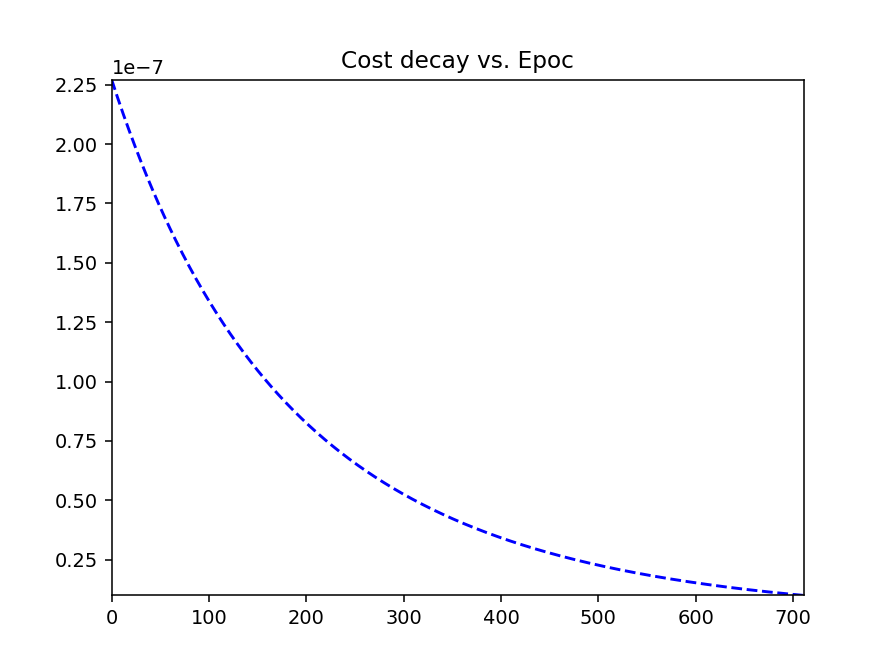

In [101]:
(T, conv_hist) = logistic_gradient_descent(theta, xpoints, Y, 0.01, 100000, 0.00000001)
print "Final theta = ", T, " reached in ", len(conv_hist), " epochs."
plt.figure()
plt.title("Cost decay vs. Epoc")
x = np.arange(0, len(conv_hist))
plt.axis([0, len(x), np.min(conv_hist), np.max(conv_hist)])

plt.plot(x, conv_hist, "b--")

plt.show()

Now try some predictions based on the fitted theta

Try regression with a 2-feature input matrix...

First plot an unbiased 3d sigmoid

<IPython.core.display.Javascript object>


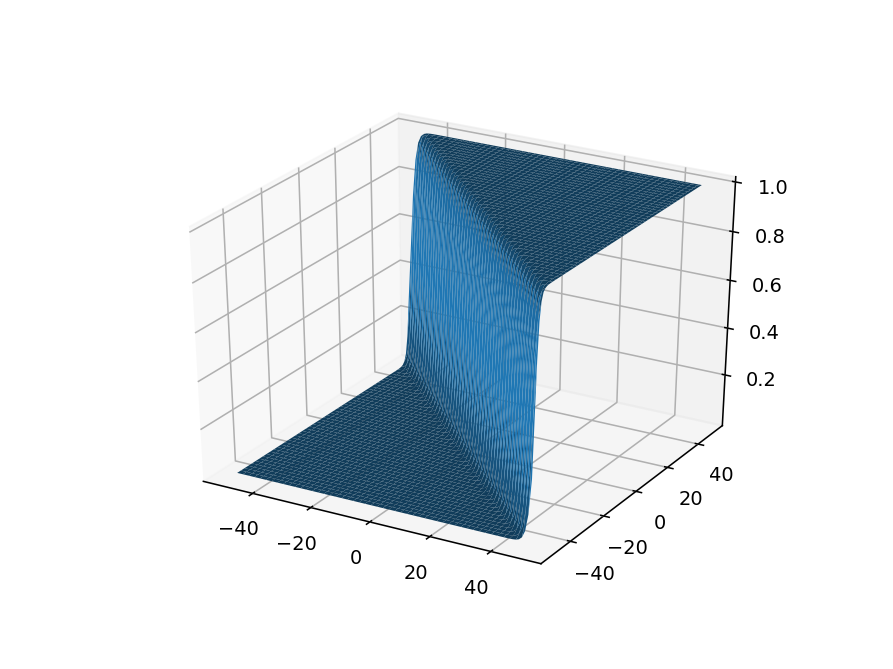

In [102]:
theta=np.array([1,1])
x_ranges = np.arange(-50,50)
x_points=np.matrix([[], []]).T

(x_0, x_1)=np.meshgrid(x_ranges,x_ranges)

x_points = np.stack((np.reshape(x_0, -1), np.reshape(x_1, -1)), axis=-1)

y_points = sigmoid(theta, x_points)
Z= y_points.reshape(x_0.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_0, x_1, Z)
plt.show()


... now generate some Y's to train our model...

In [103]:
# Set Y=1 whenever |X|>3

Y_hat = np.array([(x_points[i,0]<10) & (x_points[i,1] > 20) for i in range(0, len(x_points[:,0]))]).astype(int)
print Y_hat
# Call gradient descent
(T, conv_hist) = logistic_gradient_descent(theta, x_points, Y_hat, 0.0001, 10000, 0.0000001)
print len(conv_hist)
print "Theta=", T


[0 0 0 ..., 0 0 0]
[ 116443.72086629   19873.72086629]
[ 116366.82190832   19950.36695916]
[ 116289.91003348   20026.95399336]
[ 116212.98730551   20103.47997203]
[ 116136.05577996   20179.94291124]
[ 116059.11750331   20256.34084077]
[ 115982.17451222   20332.67180483]
[ 115905.2288326   20408.9338629]
[ 115828.28247882   20485.1250905 ]
[ 115751.33745272   20561.24358   ]
[ 115674.39574279   20637.28744151]
[ 115597.45932312   20713.25480372]
[ 115520.53015246   20789.14381481]
[ 115443.61017318   20864.95264341]
[ 115366.70131017   20940.67947953]
[ 115289.80546976   21016.32253564]
[ 115212.92453858   21091.88004764]
[ 115136.06038234   21167.35027596]
[ 115059.21484467   21242.73150668]
[ 114982.38974589   21318.02205257]
[ 114905.58688173   21393.22025431]
[ 114828.80802215   21468.32448152]
[ 114752.05491007   21543.33313393]
[ 114675.32926018   21618.24464247]
[ 114598.63275773   21693.05747031]
[ 114521.96705743   21767.77011392]
[ 114445.33378231   21842.38110401]
[ 114368.73

[ 98119.35338974  36130.25416087]
[ 98056.29792653  36179.19635554]
[ 97993.28431886  36228.05792996]
[ 97930.31242179  36276.83909095]
[ 97867.38209075  36325.5400445 ]
[ 97804.4931816   36374.16099582]
[ 97741.64555055  36422.70214931]
[ 97678.83905422  36471.16370857]
[ 97616.0735496  36519.5458764]
[ 97553.34889408  36567.84885483]
[ 97490.66494543  36616.07284508]
[ 97428.0215618   36664.21804761]
[ 97365.4186017   36712.28466208]
[ 97302.85592403  36760.27288739]
[ 97240.33338809  36808.18292165]
[ 97177.8508535   36856.01496223]
[ 97115.4081803   36903.76920569]
[ 97053.00522888  36951.44584788]
[ 96990.64186     36999.04508384]
[ 96928.31793478  37046.56710789]
[ 96866.03331473  37094.01211358]
[ 96803.78786169  37141.3802937 ]
[ 96741.5814379   37188.67184032]
[ 96679.41390594  37235.88694475]
[ 96617.28512876  37283.02579754]
[ 96555.19496965  37330.08858854]
[ 96493.14329228  37377.07550684]
[ 96431.12996066  37423.9867408 ]
[ 96369.15483916  37470.82247807]
[ 96307.21779251

[ 83335.68414187  46283.1244623 ]
[ 83279.35406653  46316.71699162]
[ 83223.03814349  46350.26229214]
[ 83166.73628438  46383.76044376]
[ 83110.44840093  46417.21152605]
[ 83054.17440495  46450.61561826]
[ 82997.91420839  46483.97279934]
[ 82941.66772327  46517.28314793]
[ 82885.43486173  46550.54674235]
[ 82829.21553599  46583.76366061]
[ 82773.00965838  46616.93398042]
[ 82716.81714133  46650.05777916]
[ 82660.63789737  46683.13513394]
[ 82604.47183911  46716.16612152]
[ 82548.31887927  46749.1508184 ]
[ 82492.17893067  46782.08930073]
[ 82436.0519062   46814.98164438]
[ 82379.93771888  46847.82792492]
[ 82323.83628179  46880.62821762]
[ 82267.74750811  46913.38259742]
[ 82211.67131113  46946.09113899]
[ 82155.60760421  46978.75391668]
[ 82099.55630081  47011.37100457]
[ 82043.51731448  47043.9424764 ]
[ 81987.49055886  47076.46840565]
[ 81931.47594766  47108.94886547]
[ 81875.47339472  47141.38392875]
[ 81819.48281391  47173.77366806]
[ 81763.50411923  47206.11815569]
[ 81707.537224

[ 65692.93187193  54894.95576905]
[ 65636.92878891  54916.14262708]
[ 65580.91364182  54937.29472467]
[ 65524.88634454  54958.41206421]
[ 65468.84681091  54979.49464784]
[ 65412.79495463  55000.54247747]
[ 65356.73068937  55021.55555479]
[ 65300.65392869  55042.53388122]
[ 65244.56458607  55063.47745797]
[ 65188.4625749  55084.386286 ]
[ 65132.34780849  55105.26036604]
[ 65076.22020007  55126.09969857]
[ 65020.07966276  55146.90428384]
[ 64963.92610961  55167.67412186]
[ 64907.75945359  55188.4092124 ]
[ 64851.57960756  55209.10955499]
[ 64795.38648431  55229.77514891]
[ 64739.17999652  55250.40599322]
[ 64682.9600568   55271.00208673]
[ 64626.72657765  55291.56342799]
[ 64570.47947149  55312.09001534]
[ 64514.21865066  55332.58184686]
[ 64457.94402737  55353.03892037]
[ 64401.65551377  55373.46123349]
[ 64345.35302191  55393.84878356]
[ 64289.03646373  55414.20156769]
[ 64232.70575109  55434.51958274]
[ 64176.36079574  55454.80282534]
[ 64120.00150936  55475.05129185]
[ 64063.6278035 

[ 51448.5451271   59002.03305437]
[ 51386.76031208  59014.16077892]
[ 51324.93849044  59026.2457603 ]
[ 51263.07953706  59038.28791991]
[ 51201.18332655  59050.28717869]
[ 51139.24973329  59062.24345704]
[ 51077.27863143  59074.15667489]
[ 51015.26989485  59086.02675163]
[ 50953.2233972   59097.85360615]
[ 50891.13901186  59109.63715684]
[ 50829.01661199  59121.37732155]
[ 50766.85607049  59133.07401762]
[ 50704.65726     59144.72716189]
[ 50642.42005292  59156.33667066]
[ 50580.14432139  59167.9024597 ]
[ 50517.82993732  59179.42444426]
[ 50455.47677235  59190.90253907]
[ 50393.08469786  59202.33665831]
[ 50330.65358499  59213.72671563]
[ 50268.18330463  59225.07262416]
[ 50205.6737274   59236.37429648]
[ 50143.12472368  59247.63164461]
[ 50080.53616357  59258.84458006]
[ 50017.90791694  59270.01301376]
[ 49955.23985339  59281.13685613]
[ 49892.53184226  59292.21601699]
[ 49829.78375264  59303.25040565]
[ 49766.99545334  59314.23993084]
[ 49704.16681294  59325.18450074]
[ 49641.297699

[ 31003.21881551  60182.89074154]
[ 30923.93912397  60175.85707274]
[ 30844.57410584  60168.72021826]
[ 30765.12357465  60161.47976354]
[ 30685.58734417  60154.13529178]
[ 30605.96522843  60146.68638393]
[ 30526.25704171  60139.13261869]
[ 30446.46259855  60131.47357248]
[ 30366.5817138   60123.70881942]
[ 30286.61420256  60115.83793136]
[ 30206.55988027  60107.86047783]
[ 30126.41856263  60099.77602602]
[ 30046.19006571  60091.58414083]
[ 29965.87420589  60083.28438478]
[ 29885.47079988  60074.87631806]
[ 29804.97966476  60066.35949847]
[ 29724.40061797  60057.73348145]
[ 29643.73347732  60048.99782004]
[ 29562.97806102  60040.15206488]
[ 29482.13418767  60031.1957642 ]
[ 29401.20167627  60022.12846379]
[ 29320.18034626  60012.94970702]
[ 29239.07001752  60003.65903478]
[ 29157.87051035  59994.25598553]
[ 29076.58164553  59984.74009523]
[ 28995.20324431  59975.11089737]
[ 28913.73512843  59965.36792292]
[ 28832.17712011  59955.51070036]
[ 28750.52904211  59945.53875563]
[ 28668.790717

[  5460.39949723  52159.75428884]
[  5357.20117017  52098.26418427]
[  5253.988147    52036.45270331]
[  5150.76212315  51974.31905907]
[  5047.52481825  51911.86247591]
[  4944.27797635  51849.08218969]
[  4841.02336613  51785.97744803]
[  4737.76278114  51722.54751067]
[  4634.49803997  51658.79164969]
[  4531.23098649  51594.70914987]
[  4427.96349007  51530.29930892]
[  4324.69744576  51465.56143783]
[  4221.4347745   51400.49486117]
[  4118.17742337  51335.09891735]
[  4014.92736572  51269.37295897]
[  3911.68660144  51203.3163531 ]
[  3808.45715712  51136.9284816 ]
[  3705.24108626  51070.20874143]
[  3602.04046948  51003.15654495]
[  3498.85741465  50935.77132023]
[  3395.69405719  50868.0525114 ]
[  3292.55256014  50799.99957892]
[  3189.43511442  50731.6119999 ]
[  3086.34393899  50662.88926845]
[  2983.28128103  50593.83089596]
[  2880.24941608  50524.43641144]
[  2777.25064829  50454.70536183]
[  2674.28731049  50384.63731232]
[  2571.36176442  50314.23184665]
[  2468.476400

Replot the surface with the fitted theta

<IPython.core.display.Javascript object>


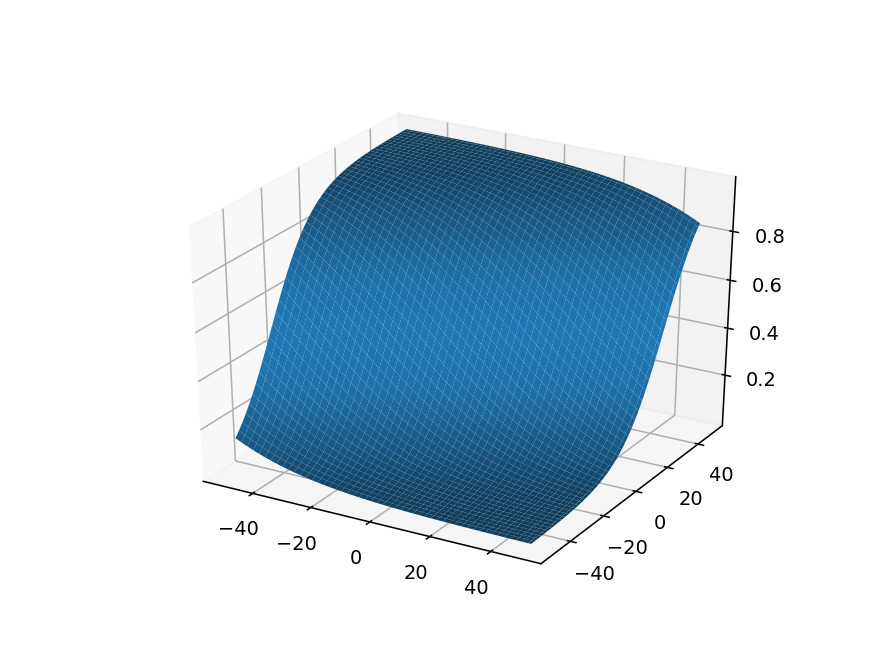

In [104]:
x_ranges = np.arange(-50,50)
x_points=np.matrix([[], []]).T

(x_0, x_1)=np.meshgrid(x_ranges,x_ranges)

x_points = np.stack((np.reshape(x_0, -1), np.reshape(x_1, -1)), axis=-1)

y_points = sigmoid(T, x_points)
Z= y_points.reshape(x_0.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_0, x_1, Z)
plt.show()

And try some predictions...

In [105]:
sigmoid(T, np.array([90,5]))

array(0.019667126371527396)

In [106]:
sigmoid(T, np.array([20,1]))

array(0.29362253886264206)

In [107]:
sigmoid(T, np.array([-10,-10]))

array(0.41393578313123924)

### Regression with Titanic Data (from scratch)
Split the data set into training and test sets

In [108]:
Y = df["Survived"].values
# Split df into test and train datasets (70%/30%)

splitNdx = int(df.shape[0]*0.7)
X_train = np.matrix(df.iloc[0:splitNdx,1:].values)
Y_train = df.iloc[0:splitNdx, 0].values
X_test = np.matrix(df.iloc[splitNdx:, 1:].values)
Y_test = df.iloc[splitNdx:, 0].values

print X_train.shape
print X_test.shape

(623, 9)
(268, 9)


Generate a random initial set of weights theta

In [109]:
theta = np.random.rand(X_train.shape[1])
print theta

[ 0.53810277  0.17440039  0.75438296  0.12076798  0.76910682  0.23570812
  0.91280987  0.31339856  0.78918931]


Run gradient descent!

In [110]:
(T , conv_hist)= logistic_gradient_descent(theta, X_train, Y_train, 0.001, 50000, 0.00000001)
print T

[[ 211.05154748   56.4602199    14.73238081    8.10741484    6.62452312
    16.81097526   36.49872966   23.91042444   16.6046946 ]]
[[ 211.02200484   56.45003017   14.73065527    8.10595       6.62280779
    16.80315552   36.49335671   23.9043689    16.60283982]]
[[ 210.99246151   56.43984033   14.72892968    8.10448516    6.62109246
    16.79533583   36.48798325   23.8983133    16.6009849 ]]
[[ 210.9629175    56.42965038   14.72720405    8.10302031    6.61937713
    16.7875162    36.48260928   23.89225763   16.59912984]]
[[ 210.93337281   56.41946032   14.72547837    8.10155546    6.61766181
    16.77969662   36.47723481   23.8862019    16.59727465]]
[[ 210.90382745   56.40927016   14.72375266    8.10009061    6.61594648
    16.77187709   36.47185983   23.88014611   16.59541933]]
[[ 210.87428141   56.39907989   14.7220269     8.09862575    6.61423116
    16.76405762   36.46648434   23.87409026   16.59356387]]
[[ 210.8447347    56.38888952   14.72030109    8.09716089    6.61251585
    

[[ 209.01166268   55.75692645   14.61322412    8.0063378     6.50617929
    16.27158135   36.12682726   23.49247644   16.4764066 ]]
[[ 208.98208013   55.74673163   14.61149593    8.00487297    6.50446451
    16.26376726   36.12142031   23.48641802   16.47454288]]
[[ 208.95249712   55.73653677   14.60976771    8.00340815    6.50274975
    16.25595329   36.11601288   23.48035958   16.47267904]]
[[ 208.92291364   55.72634188   14.60803946    8.00194333    6.50103499
    16.24813944   36.11060498   23.47430113   16.47081508]]
[[ 208.8933297    55.71614696   14.60631118    8.00047852    6.49932026
    16.2403257    36.1051966    23.46824265   16.468951  ]]
[[ 208.8637453    55.705952     14.60458286    7.99901372    6.49760553
    16.23251207   36.09978775   23.46218416   16.46708679]]
[[ 208.83416044   55.695757     14.60285451    7.99754892    6.49589082
    16.22469856   36.09437842   23.45612565   16.46522245]]
[[ 208.80457513   55.68556198   14.60112613    7.99608412    6.49417613
    

    15.76393914   35.7744056    23.09866824   16.35501409]]
[[ 207.05835155   55.08403784   14.49910052    7.90967566    6.39304153
    15.75613422   35.76896868   23.09260994   16.35314264]]
[[ 207.02874472   55.07384286   14.49737051    7.90821143    6.39132804
    15.74832947   35.76353132   23.08655167   16.35127108]]
[[ 206.99913764   55.0636479    14.49564047    7.90674722    6.38961457
    15.74052489   35.75809351   23.08049342   16.34939941]]
[[ 206.96953029   55.05345298   14.4939104     7.90528302    6.38790112
    15.73272049   35.75265526   23.07443519   16.34752762]]
[[ 206.93992269   55.0432581    14.49218032    7.90381884    6.3861877
    15.72491625   35.74721656   23.06837699   16.34565571]]
[[ 206.91031483   55.03306325   14.49045021    7.90235467    6.38447431
    15.71711219   35.74177742   23.06231882   16.3437837 ]]
[[ 206.88070672   55.02286844   14.48872008    7.90089051    6.38276094
    15.7093083    35.73633784   23.05626067   16.34191157]]
[[ 206.85109836  

[[ 204.57074962   54.22787158   14.35371531    7.78674026    6.24921152
    15.10121257   35.31072588   22.58385963   16.19554997]]
[[ 204.54113128   54.21768295   14.35198394    7.78527762    6.24750072
    15.09342517   35.30525285   22.5778056    16.19366941]]
[[ 204.51151292   54.20749444   14.35025256    7.78381501    6.24578996
    15.08563801   35.29977941   22.57175166   16.19178874]]
[[ 204.48189457   54.19730604   14.34852117    7.78235242    6.24407924
    15.07785109   35.29430557   22.56569779   16.18990797]]
[[ 204.45227621   54.18711777   14.34678977    7.78088986    6.24236855
    15.07006442   35.28883132   22.559644     16.1880271 ]]
[[ 204.42265785   54.17692962   14.34505837    7.77942732    6.24065791
    15.062278     35.28335668   22.5535903    16.18614614]]
[[ 204.39303949   54.16674159   14.34332695    7.77796481    6.23894731
    15.05449182   35.27788163   22.54753667   16.18426507]]
[[ 204.36342114   54.15655369   14.34159553    7.77650232    6.23723674
    

[[ 201.22452911   53.07755003   14.15804624    7.62164695    6.05617719
    14.22297213   34.68983183   21.90039603   15.98244653]]
[[ 201.19492881   53.06738132   14.15631476    7.62018788    6.05447185
    14.21521753   34.68431626   21.89435481   15.9805556 ]]
[[ 201.16532884   53.05721284   14.15458329    7.61872886    6.05276657
    14.20746327   34.67880034   21.88831374   15.97866458]]
[[ 201.1357292    53.04704459   14.15285183    7.61726987    6.05106134
    14.19970935   34.67328408   21.88227281   15.97677348]]
[[ 201.1061299    53.03687658   14.15112038    7.61581092    6.04935618
    14.19195577   34.66776747   21.87623204   15.9748823 ]]
[[ 201.07653093   53.02670881   14.14938893    7.61435201    6.04765107
    14.18420252   34.66225051   21.87019142   15.97299104]]
[[ 201.04693231   53.01654127   14.1476575     7.61289314    6.04594602
    14.17644963   34.65673321   21.86415095   15.97109969]]
[[ 201.01733403   53.00637398   14.14592607    7.6114343     6.04424102
    

    13.37988202   34.08669003   21.24291009   15.77588037]]
[[ 197.97109371   51.96060488   13.96766223    7.46140933    5.86896958
    13.37216906   34.08113944   21.23688875   15.77398133]]
[[ 197.94154694   51.95046776   13.9659325     7.45995528    5.86727153
    13.36445653   34.07558856   21.23086762   15.77208223]]
[[ 197.91200081   51.94033098   13.96420279    7.45850128    5.86557355
    13.35674443   34.07003739   21.22484671   15.77018306]]
[[ 197.88245533   51.93019454   13.9624731     7.45704734    5.86387566
    13.34903275   34.06448593   21.21882602   15.76828383]]
[[ 197.8529105    51.92005845   13.96074344    7.45559345    5.86217783
    13.34132151   34.05893417   21.21280555   15.76638453]]
[[ 197.82336633   51.9099227    13.9590138     7.45413961    5.86048008
    13.33361069   34.05338212   21.20678529   15.76448517]]
[[ 197.79382281   51.89978729   13.95728419    7.45268582    5.85878241
    13.3259003    34.04782978   21.20076526   15.76258574]]
[[ 197.76427995 

[[ 195.60962273   51.15079186   13.82937159    7.34526106    5.7333755
    12.75658141   33.63618365   20.75593263   15.62185878]]
[[ 195.58013647   51.14068504   13.82764424    7.34381158    5.73168395
    12.74890554   33.6306109    20.74993073   15.61995492]]
[[ 195.55065107   51.13057864   13.82591693    7.34236217    5.72999248
    12.74123017   33.6250379    20.7439291    15.61805101]]
[[ 195.52116654   51.12047266   13.82418965    7.34091283    5.72830109
    12.73355528   33.61946464   20.73792772   15.61614705]]
[[ 195.49168288   51.1103671    13.82246241    7.33946354    5.7266098
    12.72588089   33.61389113   20.73192662   15.61424304]]
[[ 195.46220011   51.10026195   13.82073521    7.33801432    5.72491859
    12.71820698   33.60831737   20.72592578   15.61233897]]
[[ 195.43271821   51.09015723   13.81900804    7.33656516    5.72322747
    12.71053357   33.60274335   20.71992521   15.61043485]]
[[ 195.40323719   51.08005293   13.81728091    7.33511606    5.72153644
    12

    12.16702889   33.20637814   20.29460283   15.4751177 ]]
[[ 193.31251013   50.3637829    13.69475663    7.23239764    5.60170774
    12.15939298   33.20078738   20.288623     15.4732102 ]]
[[ 193.28309979   50.35371138   13.69303249    7.23095336    5.60002345
    12.15175761   33.1951964    20.28264348   15.47130267]]
[[ 193.25369053   50.34364035   13.69130841    7.22950915    5.59833925
    12.14412279   33.18960521   20.27666427   15.46939509]]
[[ 193.22428236   50.33356982   13.68958437    7.22806502    5.59665516
    12.13648852   33.1840138    20.27068537   15.46748747]]
[[ 193.19487527   50.32349977   13.68786038    7.22662096    5.59497116
    12.1288548    33.17842219   20.26470678   15.46557981]]
[[ 193.16546927   50.31343021   13.68613643    7.22517697    5.59328726
    12.12122163   33.17283036   20.2587285    15.46367211]]
[[ 193.13606436   50.30336115   13.68441253    7.22373305    5.59160346
    12.11358901   33.16723831   20.25275053   15.46176437]]
[[ 193.10666054 

    11.48207869   32.70241027   19.75772331   15.30329581]]
[[ 190.67021448   49.45940896   13.53978842    7.10271137    5.45053492
    11.47449506   32.69680223   19.75177358   15.30138521]]
[[ 190.64091186   49.449385     13.53806906    7.10127396    5.44886012
    11.46691204   32.69119402   19.74582421   15.29947459]]
[[ 190.61161055   49.43936161   13.53634975    7.09983663    5.44718543
    11.45932964   32.68558565   19.7398752    15.29756394]]
[[ 190.58231057   49.42933879   13.53463051    7.09839938    5.44551085
    11.45174785   32.67997711   19.73392655   15.29565326]]
[[ 190.5530119    49.41931655   13.53291132    7.09696222    5.44383639
    11.44416667   32.6743684    19.72797827   15.29374255]]
[[ 190.52371455   49.40929487   13.53119219    7.09552513    5.44216203
    11.43658612   32.66875952   19.72203034   15.29183182]]
[[ 190.49441853   49.39927376   13.52947313    7.09408813    5.44048779
    11.42900618   32.66315048   19.71608278   15.28992106]]
[[ 190.46512384 

[[ 187.28052102   48.30063971   13.34077141    6.93654263    5.25704053
    10.59914239   32.045253     19.06418978   15.07960819]]
[[ 187.25138769   48.2906874    13.33905981    6.93511539    5.25537965
    10.59163533   32.03962857   19.05828586   15.07769539]]
[[ 187.22225597   48.28073576   13.33734829    6.93368825    5.25371889
    10.58412896   32.03400404   19.05238236   15.07578258]]
[[ 187.19312585   48.27078478   13.33563684    6.9322612     5.25205827
    10.57662329   32.0283794    19.04647929   15.07386976]]
[[ 187.16399735   48.26083447   13.33392547    6.93083425    5.25039778
    10.56911831   32.02275464   19.04057664   15.07195693]]
[[ 187.13487045   48.25088484   13.33221417    6.92940739    5.24873741
    10.56161403   32.01712978   19.03467441   15.07004409]]
[[ 187.10574517   48.24093587   13.33050295    6.92798062    5.24707717
    10.55411045   32.01150481   19.02877261   15.06813124]]
[[ 187.0766215    48.23098757   13.3287918     6.92655395    5.24541706
    

    10.12011877   31.68508753   18.68721344   14.95717491]]
[[ 185.39029531   47.65516178   13.22967862    6.84397238    5.14935546
    10.1126575    31.67945703   18.68133765   14.95526176]]
[[ 185.3612712    47.64525449   13.22797215    6.84255147    5.14770318
    10.10519698   31.67382644   18.67546231   14.95334861]]
[[ 185.33224885   47.63534792   13.22626576    6.84113066    5.14605103
    10.09773719   31.66819578   18.66958742   14.95143547]]
[[ 185.30322826   47.62544207   13.22455945    6.83970995    5.14439902
    10.09027814   31.66256504   18.663713     14.94952232]]
[[ 185.27420943   47.61553695   13.22285323    6.83828935    5.14274715
    10.08281983   31.65693422   18.65783903   14.94760918]]
[[ 185.24519237   47.60563254   13.22114709    6.83686884    5.14109541
    10.07536226   31.65130332   18.65196552   14.94569603]]
[[ 185.21617707   47.59572885   13.21944103    6.83544844    5.13944382
    10.06790543   31.64567235   18.64609246   14.94378288]]
[[ 185.18716354 

     9.64411013   31.3245964    18.31210306   14.8347384 ]]
[[ 183.53639332   47.02257777   13.12063701    6.75324161    5.04389012
     9.63669731   31.31896183   18.30625747   14.8328255 ]]
[[ 183.50748639   47.01271808   13.1189361     6.75182735    5.04224684
     9.62928527   31.31332721   18.30041237   14.83091262]]
[[ 183.47858136   47.00285916   13.11723529    6.7504132     5.04060371
     9.621874     31.30769255   18.29456775   14.82899974]]
[[ 183.44967825   46.99300102   13.11553457    6.74899916    5.03896071
     9.61446351   31.30205784   18.28872363   14.82708688]]
[[ 183.42077704   46.98314364   13.11383393    6.74758523    5.03731787
     9.60705381   31.29642308   18.28288      14.82517402]]
[[ 183.39187774   46.97328703   13.11213339    6.7461714     5.03567516
     9.59964488   31.29078827   18.27703685   14.82326117]]
[[ 183.36298036   46.9634312    13.11043295    6.74475768    5.03403261
     9.59223673   31.28515342   18.2711942    14.82134833]]
[[ 183.3340849  

[[ 180.25380691   45.90370705   12.92734942    6.59273042    4.85751792
     8.79688066   30.6764285    17.64317951   14.61484735]]
[[ 180.22513135   45.89393984   12.92565967    6.59132901    4.85589192
     8.78956118   30.67079163   17.63739321   14.61293637]]
[[ 180.19645794   45.88417348   12.92397003    6.58992772    4.85426609
     8.78224254   30.66515477   17.63160745   14.61102543]]
[[ 180.16778669   45.87440797   12.92228049    6.58852654    4.85264042
     8.77492475   30.65951791   17.62582223   14.60911451]]
[[ 180.1391176    45.86464332   12.92059106    6.58712549    4.8510149
     8.76760781   30.65388107   17.62003756   14.60720361]]
[[ 180.11045067   45.85487952   12.91890173    6.58572455    4.84938954
     8.76029172   30.64824423   17.61425344   14.60529274]]
[[ 180.0817859    45.84511658   12.91721251    6.58432373    4.84776434
     8.75297647   30.64260741   17.60846986   14.60338189]]
[[ 180.05312329   45.8353545    12.91552339    6.58292303    4.84613931
     

[[ 178.10925585   45.17358098   12.80091661    6.48795867    4.73601626
     8.25030438   30.2537173    17.21074405   14.47160277]]
[[ 178.08074754   45.1638797    12.79923503    6.48656637    4.73440247
     8.24304989   30.24808234   17.20499972   14.46969404]]
[[ 178.05224153   45.15417932   12.79755356    6.4851742     4.73278886
     8.23579627   30.24244743   17.19925597   14.46778535]]
[[ 178.02373783   45.14447985   12.79587221    6.48378215    4.73117541
     8.22854355   30.23681255   17.19351279   14.4658767 ]]
[[ 177.99523644   45.13478128   12.79419097    6.48239023    4.72956213
     8.22129172   30.23117773   17.18777019   14.46396808]]
[[ 177.96673736   45.12508362   12.79250985    6.48099843    4.72794902
     8.21404077   30.22554294   17.18202816   14.46205949]]
[[ 177.9382406    45.11538687   12.79082884    6.47960676    4.72633607
     8.20679071   30.21990821   17.17628672   14.46015094]]
[[ 177.90974616   45.10569103   12.78914794    6.47821521    4.72472329
    

[[ 174.95935376   44.10241226   12.61497721    6.33419563    4.55793072
     7.45058947   29.62860522   16.57673803   14.25997843]]
[[ 174.93111345   44.09281549   12.61330887    6.33281773    4.55633615
     7.44343666   29.62297792   16.5710603    14.25807442]]
[[ 174.90287567   44.08321969   12.61164066    6.33143996    4.55474176
     7.43628481   29.61735071   16.56538319   14.25617046]]
[[ 174.8746404    44.07362487   12.60997257    6.33006233    4.55314754
     7.42913389   29.6117236    16.5597067    14.25426655]]
[[ 174.84640766   44.06403103   12.60830461    6.32868483    4.55155351
     7.42198392   29.60609658   16.55403084   14.25236269]]
[[ 174.81817745   44.05443817   12.60663677    6.32730746    4.54995965
     7.4148349    29.60046966   16.5483556    14.25045888]]
[[ 174.78994977   44.04484629   12.60496905    6.32593023    4.54836597
     7.40768683   29.59484284   16.54268099   14.24855512]]
[[ 174.76172461   44.03525539   12.60330147    6.32455314    4.54677247
    

     6.52881732   28.89801184   15.8440007    14.0129212 ]]
[[ 171.28200018   42.85378154   12.39752891    6.15486405    4.35060228
     6.5217913    28.89240063   15.83840729   14.01102475]]
[[ 171.25410536   42.84431797   12.39587785    6.15350443    4.349032
     6.51476629   28.88678957   15.83281455   14.00912836]]
[[ 171.22621329   42.83485545   12.39422693    6.15214495    4.34746191
     6.50774228   28.88117866   15.82722248   14.00723204]]
[[ 171.19832397   42.82539398   12.39257614    6.15078562    4.34589202
     6.50071927   28.87556791   15.82163109   14.00533578]]
[[ 171.17043741   42.81593358   12.3909255     6.14942644    4.34432231
     6.49369727   28.86995731   15.81604038   14.00343959]]
[[ 171.1425536    42.80647423   12.38927499    6.1480674     4.3427528
     6.48667628   28.86434686   15.81045034   14.00154347]]
[[ 171.11467255   42.79701593   12.38762462    6.1467085     4.34118347
     6.4796563    28.85873657   15.80486097   13.99964742]]
[[ 171.08679427   4

[[ 169.30839948   42.18452185   12.28065301    6.0586947     4.23959407
     6.02553847   28.49442095   15.4430181    13.87655336]]
[[ 169.28070408   42.17513457   12.27901201    6.05734553    4.23803763
     6.01858591   28.48882185   15.4374741    13.87466199]]
[[ 169.25301156   42.16574839   12.27737116    6.05599651    4.23648138
     6.01163438   28.48322293   15.4319308    13.8727707 ]]
[[ 169.2253219    42.1563633    12.27573046    6.05464764    4.23492534
     6.00468389   28.4776242    15.4263882    13.87087948]]
[[ 169.19763512   42.14697931   12.2740899     6.05329893    4.2333695
     5.99773444   28.47202565   15.4208463    13.86898835]]
[[ 169.1699512    42.13759641   12.27244948    6.05195036    4.23181385
     5.99078602   28.46642728   15.4153051    13.86709728]]
[[ 169.14227016   42.12821461   12.27080921    6.05060194    4.2302584
     5.98383864   28.4608291    15.4097646    13.86520629]]
[[ 169.11459199   42.1188339    12.26916909    6.04925367    4.22870315
     5

     5.14416165   27.77937423   14.73918347   13.63510926]]
[[ 165.75989698   40.98277532   12.07019404    5.88591278    4.04047891
     5.1373448    27.77380207   14.73373167   13.63322847]]
[[ 165.73258392   40.97353338   12.0685725     5.8845835     4.03894873
     5.13052903   27.76823015   14.72828061   13.63134776]]
[[ 165.70527392   40.9642926    12.06695112    5.88325437    4.03741875
     5.12371435   27.76265847   14.72283028   13.62946714]]
[[ 165.67796698   40.95505297   12.06532989    5.88192541    4.03588899
     5.11690075   27.75708703   14.7173807    13.62758661]]
[[ 165.6506631    40.94581451   12.06370882    5.8805966     4.03435943
     5.11008824   27.75151582   14.71193186   13.62570617]]
[[ 165.62336228   40.9365772    12.06208791    5.87926795    4.03283008
     5.10327681   27.74594486   14.70648377   13.62382582]]
[[ 165.59606453   40.92734106   12.06046715    5.87793946    4.03130094
     5.09646647   27.74037413   14.70103641   13.62194556]]
[[ 165.56876985 

[[ 162.77409187   39.97320507   11.89278021    5.74065457    3.87342641
     4.39418618   27.16240131   14.13862281   13.42691436]]
[[ 162.74712338   39.96409327   11.89117636    5.73934308    3.87191963
     4.38749174   27.15685791   14.13325505   13.42504422]]
[[ 162.72015809   39.95498267   11.88957268    5.73803175    3.87041308
     4.38079843   27.15131478   14.12788807   13.42317419]]
[[ 162.69319601   39.94587328   11.88796917    5.73672059    3.86890674
     4.37410623   27.14577194   14.12252187   13.42130425]]
[[ 162.66623714   39.9367651    11.88636582    5.73540959    3.86740061
     4.36741516   27.14022939   14.11715643   13.41943442]]
[[ 162.63928147   39.92765813   11.88476264    5.73409875    3.86589471
     4.36072521   27.13468711   14.11179178   13.41756469]]
[[ 162.61232902   39.91855237   11.88315962    5.73278809    3.86438902
     4.35403638   27.12914512   14.10642789   13.41569506]]
[[ 162.58537977   39.90944781   11.88155677    5.73147758    3.86288355
    

     3.72375888   26.60400031   13.60042904   13.23856327]]
[[ 160.04002423   39.0500893    11.73005205    5.60774157    3.72086394
     3.71717915   26.59848721   13.59514072   13.23670397]]
[[ 160.01338888   39.04110271   11.72846544    5.60644718    3.71937962
     3.71060058   26.59297442   13.5898532    13.23484478]]
[[ 159.98675686   39.03211737   11.726879      5.60515297    3.71789553
     3.70402315   26.58746196   13.58456648   13.2329857 ]]
[[ 159.96012817   39.02313327   11.72529274    5.60385893    3.71641166
     3.69744688   26.58194981   13.57928056   13.23112674]]
[[ 159.93350281   39.01415042   11.72370665    5.60256506    3.71492802
     3.69087176   26.57643799   13.57399544   13.22926789]]
[[ 159.90688078   39.00516882   11.72212074    5.60127136    3.7134446
     3.68429779   26.57092648   13.56871112   13.22740915]]
[[ 159.88026208   38.99618847   11.72053499    5.59997783    3.7119614
     3.67772497   26.5654153    13.5634276    13.22555052]]
[[ 159.85364671   

[[ 158.36853804   38.48638505   11.63043578    5.52653037    3.62779098
     3.30498618   26.25182002   13.26359838   13.11979892]]
[[ 158.34211442   38.47747776   11.62886019    5.52524683    3.62632086
     3.2984806    26.24632806   13.25836171   13.11794702]]
[[ 158.31569418   38.46857175   11.62728477    5.52396345    3.62485097
     3.29197617   26.24083645   13.25312586   13.11609523]]
[[ 158.28927734   38.459667     11.62570953    5.52268025    3.62338131
     3.28547292   26.23534518   13.24789082   13.11424357]]
[[ 158.2628639    38.45076353   11.62413447    5.52139723    3.62191187
     3.27897083   26.22985426   13.24265659   13.11239203]]
[[ 158.23645386   38.44186132   11.62255958    5.52011438    3.62044266
     3.27246991   26.22436367   13.23742318   13.1105406 ]]
[[ 158.21004721   38.43296039   11.62098487    5.5188317     3.61897368
     3.26597016   26.21887344   13.23219059   13.1086893 ]]
[[ 158.18364397   38.42406073   11.61941034    5.5175492     3.61750493
    

     2.89099034   25.90103939   12.93010313   13.00152076]]
[[ 156.65810848   37.91006824   11.52839316    5.44346298    3.53270836
     2.88455989   25.89557004   12.92491905   12.99967666]]
[[ 156.63190764   37.90124421   11.52682921    5.44219081    3.53125313
     2.87813063   25.89010106   12.91973579   12.99783268]]
[[ 156.60571027   37.89242148   11.52526543    5.44091882    3.52979812
     2.87170254   25.88463244   12.91455336   12.99598882]]
[[ 156.57951636   37.88360003   11.52370184    5.43964701    3.52834335
     2.86527564   25.87916419   12.90937176   12.99414509]]
[[ 156.55332591   37.87477989   11.52213843    5.43837537    3.52688881
     2.85884991   25.8736963    12.90419099   12.99230149]]
[[ 156.52713892   37.86596103   11.5205752     5.43710391    3.5254345
     2.85242537   25.86822877   12.89901105   12.99045801]]
[[ 156.5009554    37.85714347   11.51901215    5.43583263    3.52398042
     2.84600202   25.86276161   12.89383194   12.98861465]]
[[ 156.47477534  

[[ 153.38435738   36.80851228   11.33278086    5.2845741     3.35118256
     2.08384608   25.2094604    12.27842114   12.76834886]]
[[ 153.35859979   36.79985337   11.3312402     5.28332451    3.34975679
     2.07756732   25.20404001   12.27334388   12.76652134]]
[[ 153.33284578   36.79119579   11.32969972    5.2820751     3.34833126
     2.07128977   25.19862004   12.26826747   12.76469395]]
[[ 153.30709534   36.78253954   11.32815944    5.28082587    3.34690596
     2.06501343   25.19320046   12.26319191   12.7628667 ]]
[[ 153.28134848   36.77388461   11.32661934    5.27957683    3.34548091
     2.05873829   25.1877813    12.25811721   12.76103958]]
[[ 153.25560519   36.76523102   11.32507943    5.27832796    3.34405609
     2.05246436   25.18236254   12.25304336   12.75921261]]
[[ 153.22986548   36.75657876   11.32353971    5.27707928    3.3426315
     2.04619163   25.1769442    12.24797036   12.75738576]]
[[ 153.20412934   36.74792782   11.32200018    5.27583078    3.34120716
     

[[ 148.98210798   35.33049534   11.0690941     5.07112757    3.10808287
     1.01570814   24.27804363   11.41288633   12.45428351]]
[[ 148.95697975   35.32206985   11.0675868     5.06990992    3.10669867
     1.00964043   24.27269813   11.40795905   12.45248076]]
[[ 148.93185522   35.31364573   11.0660797     5.06869246    3.10531471
     1.00357395   24.26735308   11.40303264   12.45067816]]
[[ 148.90673438   35.30522297   11.06457279    5.06747519    3.10393099
     0.99750871   24.2620085    11.39810711   12.44887572]]
[[ 148.88161725   35.29680159   11.06306608    5.0662581     3.10254752
     0.99144469   24.25666437   11.39318246   12.44707342]]
[[ 148.85650381   35.28838158   11.06155957    5.0650412     3.10116429
     0.98538191   24.2513207    11.38825869   12.44527128]]
[[ 148.83139408   35.27996293   11.06005326    5.06382449    3.0997813
     0.97932036   24.24597749   11.38333581   12.44346928]]
[[ 148.80628805   35.27154565   11.05854714    5.06260797    3.09839856
     

[[ 145.77130415   34.25496973   10.87629369    4.91560762    2.93154079
     0.24318013   23.59235632   10.78457176   12.22299375]]
[[ 145.74665776   34.24672227   10.87481215    4.91441437    2.93018823
     0.23727217   23.58707225   10.77975894   12.22121097]]
[[ 145.72201514   34.2384762    10.87333081    4.91322131    2.92883592
     0.23136546   23.58178866   10.77494702   12.21942834]]
[[ 145.6973763    34.23023152   10.87184967    4.91202844    2.92748385
     0.22545999   23.57650557   10.770136     12.21764587]]
[[ 145.67274123   34.22198823   10.87036874    4.91083576    2.92613203
     0.21955576   23.57122297   10.76532587   12.21586356]]
[[ 145.64810992   34.21374633   10.86888801    4.90964327    2.92478047
     0.21365278   23.56594087   10.76051663   12.21408141]]
[[ 145.62348239   34.20550582   10.86740748    4.90845097    2.92342914
     0.20775104   23.56065927   10.75570829   12.21229941]]
[[ 145.59885864   34.19726671   10.86592715    4.90725886    2.92207807
    

[[ 141.03711527   32.67318727   10.59126099    4.68655589    2.67249212
    -0.88526065   22.57159967    9.86310399   11.87844205]]
[[ 141.01321222   32.66521348   10.58981953    4.6854002     2.67118814
    -0.89092488   22.56641648    9.85846726   11.87669154]]
[[ 140.98931302   32.6572411    10.58837827    4.68424471    2.66988441
    -0.89658785   22.56123384    9.85383144   11.87494119]]
[[ 140.96541767   32.64927013   10.58693723    4.68308941    2.66858093
    -0.90224957   22.55605174    9.84919653   11.87319102]]
[[ 140.94152616   32.64130058   10.58549639    4.68193431    2.6672777
    -0.90791004   22.55087017    9.84456253   11.87144102]]
[[ 140.91763851   32.63333245   10.58405576    4.6807794     2.66597473
    -0.91356925   22.54568915    9.83992944   11.8696912 ]]
[[ 140.8937547    32.62536572   10.58261535    4.67962469    2.664672
    -0.91922721   22.54050867    9.83529726   11.86794154]]
[[ 140.86987474   32.61740041   10.58117514    4.67847017    2.66336952
    -0.

[[ 139.13705544   32.03975864   10.47660514    4.59471624    2.56896732
    -1.33443531   22.15866999    9.49504577   11.7389473 ]]
[[ 139.11346114   32.03189821   10.47518044    4.59357614    2.56768345
    -1.33999918   22.15353071    9.49048201   11.73721068]]
[[ 139.08987072   32.02403921   10.47375595    4.59243624    2.56639982
    -1.3455618    22.14839199    9.48591917   11.73547423]]
[[ 139.06628417   32.01618162   10.47233168    4.59129653    2.56511645
    -1.35112316   22.14325382    9.48135723   11.73373796]]
[[ 139.04270148   32.00832545   10.47090761    4.59015702    2.56383333
    -1.35668327   22.13811621    9.47679622   11.73200187]]
[[ 139.01912267   32.00047071   10.46948376    4.58901771    2.56255046
    -1.36224212   22.13297916    9.47223612   11.73026595]]
[[ 138.99554773   31.99261738   10.46806011    4.58787859    2.56126784
    -1.36779971   22.12784267    9.46767693   11.72853021]]
[[ 138.97197666   31.98476548   10.46663668    4.58673966    2.55998548
    

    -1.78650556   21.73911772    9.12385666   11.59713284]]
[[ 137.19191946   31.39218055   10.35907377    4.50075392    2.46326317
    -1.79196655   21.7340248     9.11936798   11.59541081]]
[[ 137.16864712   31.38443817   10.35766662    4.49963007    2.46200022
    -1.79742628   21.72893246    9.11488022   11.59368895]]
[[ 137.14537866   31.37669721   10.35625969    4.49850642    2.46073752
    -1.80288476   21.72384069    9.11039337   11.59196728]]
[[ 137.1221141    31.36895767   10.35485296    4.49738296    2.45947507
    -1.80834199   21.7187495     9.10590744   11.59024579]]
[[ 137.09885342   31.36121956   10.35344645    4.4962597     2.45821288
    -1.81379796   21.71365888    9.10142243   11.58852448]]
[[ 137.07559663   31.35348287   10.35204015    4.49513664    2.45695094
    -1.81925267   21.70856884    9.09693833   11.58680335]]
[[ 137.05234373   31.3457476    10.35063407    4.49401377    2.45568925
    -1.82470614   21.70347937    9.09245516   11.58508239]]
[[ 137.02909472 

[[ 132.77253543   29.92431615   10.09144891    4.28749276    2.22419393
    -2.82249052   20.76204766    8.27023938   11.2664836 ]]
[[ 132.75001554   29.91684901   10.09008306    4.28640688    2.22297974
    -2.82770878   20.75706936    8.26592886   11.26479733]]
[[ 132.72749956   29.9093833    10.08871741    4.28532119    2.22176581
    -2.8329258    20.75209167    8.26161926   11.26311126]]
[[ 132.70498748   29.90191901   10.08735199    4.2842357     2.22055212
    -2.83814157   20.74711458    8.25731057   11.26142537]]
[[ 132.68247931   29.89445615   10.08598677    4.2831504     2.21933869
    -2.84335609   20.74213811    8.25300281   11.25973967]]
[[ 132.65997505   29.88699471   10.08462178    4.2820653     2.21812551
    -2.84856937   20.73716224    8.24869596   11.25805416]]
[[ 132.63747468   29.8795347    10.083257      4.2809804     2.21691258
    -2.85378139   20.73218698    8.24439003   11.25636884]]
[[ 132.61497823   29.87207612   10.08189243    4.2798957     2.21569991
    

[[ 127.65255042   28.23011165    9.7803573     4.04084547    1.94926072
    -3.999864     19.62364907    7.29478229   10.88039525]]
[[ 127.63093595   28.22297465    9.77904161    4.03980526    1.94810498
    -4.00479499   19.61881543    7.29068439   10.87875366]]
[[ 127.60932537   28.21583907    9.77772614    4.03876525    1.9469495
    -4.00972476   19.61398243    7.2865874    10.87711226]]
[[ 127.58771868   28.20870491    9.77641088    4.03772544    1.94579426
    -4.0146533    19.60915007    7.28249133   10.87547107]]
[[ 127.56611589   28.20157217    9.77509584    4.03668582    1.94463927
    -4.01958061   19.60431834    7.27839617   10.87383007]]
[[ 127.54451699   28.19444084    9.77378102    4.0356464     1.94348453
    -4.02450669   19.59948726    7.27430192   10.87218926]]
[[ 127.52292199   28.18731093    9.77246642    4.03460717    1.94233005
    -4.02943154   19.59465681    7.27020858   10.87054865]]
[[ 127.50133087   28.18018243    9.77115203    4.03356814    1.94117582
    -

[[ 122.43167989   26.5101497     9.46197229    3.7898654     1.67138112
    -5.180782     18.44940703    6.31021202   10.48094975]]
[[ 122.41102203   26.50336039    9.46071016    3.78887348    1.67028691
    -5.18541309   18.44473428    6.30633801   10.4793574 ]]
[[ 122.39036802   26.49657249    9.45944825    3.78788176    1.66919295
    -5.19004298   18.44006219    6.30246491   10.47776525]]
[[ 122.36971786   26.48978598    9.45818656    3.78689023    1.66809924
    -5.19467167   18.43539077    6.2985927    10.4761733 ]]
[[ 122.34907155   26.48300086    9.45692508    3.7858989     1.66700577
    -5.19929916   18.43072001    6.29472139   10.47458156]]
[[ 122.32842908   26.47621715    9.45566382    3.78490776    1.66591255
    -5.20392545   18.42604991    6.29085098   10.47299002]]
[[ 122.30779045   26.46943482    9.45440278    3.78391682    1.66481957
    -5.20855055   18.42138048    6.28698147   10.47139868]]
[[ 122.28715567   26.4626539     9.45314195    3.78292607    1.66372685
    

[[ 117.50452697   24.89466078    9.16041549    3.553566      1.41166617
    -6.27556834   17.329073      5.39141208   10.09844446]]
[[ 117.48479909   24.88820848    9.15920597    3.55262109    1.41063159
    -6.27991121   17.32456398    5.38775499   10.09690187]]
[[ 117.46507499   24.88175756    9.15799666    3.55167636    1.40959725
    -6.28425292   17.32005563    5.38409879   10.09535947]]
[[ 117.44535465   24.87530799    9.15678757    3.55073183    1.40856315
    -6.28859346   17.31554796    5.38044346   10.09381729]]
[[ 117.42563809   24.8688598     9.15557869    3.54978748    1.40752929
    -6.29293284   17.31104097    5.37678901   10.09227531]]
[[ 117.40592529   24.86241296    9.15437003    3.54884333    1.40649567
    -6.29727106   17.30653466    5.37313543   10.09073354]]
[[ 117.38621627   24.85596749    9.15316158    3.54789937    1.4054623
    -6.30160811   17.30202902    5.36948274   10.08919197]]
[[ 117.36651102   24.84952339    9.15195334    3.5469556     1.40442916
    -

[[ 112.85831936   23.37878358    8.87509121    3.33131653    1.16925375
    -7.28896326   16.26209573    4.53522424    9.7326385 ]]
[[ 112.83948939   23.3726558     8.87393297    3.33041706    1.16827658
    -7.29303082   16.25775117    4.53177588    9.73114563]]
[[ 112.82066309   23.36652934    8.87277494    3.32951777    1.16729965
    -7.29709727   16.25340729    4.52832839    9.72965296]]
[[ 112.80184047   23.36040421    8.87161712    3.32861867    1.16632294
    -7.30116259   16.2490641     4.52488174    9.7281605 ]]
[[ 112.78302152   23.35428041    8.87045951    3.32771976    1.16534648
    -7.30522678   16.24472159    4.52143595    9.72666825]]
[[ 112.76420625   23.34815794    8.86930211    3.32682103    1.16437025
    -7.30928986   16.24037977    4.51799101    9.7251762 ]]
[[ 112.74539466   23.34203679    8.86814492    3.32592249    1.16339425
    -7.31335182   16.23603864    4.51454692    9.72368436]]
[[ 112.72658674   23.33591696    8.86698795    3.32502414    1.16241848
    

[[ 108.80350247   22.06233037    8.62532793    3.13788113    0.95987717
    -8.15713523   15.32283311    3.79693621    9.40919189]]
[[ 108.78547038   22.05649025    8.62421566    3.13702211    0.95895089
    -8.16096054   15.31863966    3.79367273    9.40774454]]
[[ 108.76744186   22.05065143    8.62310359    3.13616326    0.95802484
    -8.16478477   15.31444691    3.79041008    9.4062974 ]]
[[ 108.74941691   22.04481388    8.62199173    3.1353046     0.95709902
    -8.16860792   15.31025484    3.78714826    9.40485047]]
[[ 108.73139554   22.03897763    8.62088007    3.13444612    0.95617343
    -8.17242999   15.30606346    3.78388726    9.40340374]]
[[ 108.71337774   22.03314266    8.61976862    3.13358782    0.95524806
    -8.17625098   15.30187276    3.78062709    9.40195722]]
[[ 108.69536351   22.02730898    8.61865738    3.1327297     0.95432292
    -8.18007088   15.29768276    3.77736775    9.40051091]]
[[ 108.67735286   22.02147659    8.61754634    3.13187176    0.95339801
    

[[ 106.96488785   21.46752755    8.51184592    3.05034997    0.86566118
    -8.54550067   14.89451762    3.46511998    9.26120056]]
[[ 106.94722136   21.46181904    8.51075483    3.04950949    0.86475818
    -8.54921571   14.89039493    3.46194102    9.25977449]]
[[ 106.9295584    21.45611179    8.50966394    3.0486692     0.86385541
    -8.55292968   14.88627292    3.45876288    9.25834862]]
[[ 106.91189895   21.45040581    8.50857326    3.04782909    0.86295287
    -8.5566426    14.88215161    3.45558554    9.25692296]]
[[ 106.89424303   21.4447011     8.50748279    3.04698916    0.86205055
    -8.56035446   14.87803098    3.45240902    9.25549751]]
[[ 106.87659064   21.43899766    8.50639251    3.0461494     0.86114845
    -8.56406526   14.87391103    3.44923332    9.25407226]]
[[ 106.85894176   21.43329548    8.50530245    3.04530983    0.86024658
    -8.567775     14.86979177    3.44605843    9.25264722]]
[[ 106.84129641   21.42759457    8.50421258    3.04447043    0.85934493
    

[[ 102.707031     20.09554651    8.24850472    2.84812722    0.64934915
    -9.4313856    13.8970217     2.70431864    8.91521073]]
[[ 102.69021902   20.09014506    8.24746346    2.84733017    0.64850049
    -9.43484471   13.89306795    2.70133671    8.91383538]]
[[ 102.67341043   20.08474484    8.24642239    2.8465333     0.64765204
    -9.4383028    13.88911488    2.69835555    8.91246024]]
[[ 102.65660524   20.07934583    8.24538152    2.8457366     0.64680381
    -9.44175988   13.88516249    2.69537518    8.91108531]]
[[ 102.63980344   20.07394803    8.24434085    2.84494008    0.6459558
    -9.44521595   13.88121078    2.6923956     8.90971057]]
[[ 102.62300503   20.06855146    8.24330038    2.84414373    0.645108
    -9.44867101   13.87725975    2.68941679    8.90833605]]
[[ 102.60621001   20.0631561     8.2422601     2.84334755    0.64426041
    -9.45212505   13.87330941    2.68643876    8.90696172]]
[[ 102.58941839   20.05776196    8.24122003    2.84255154    0.64341304
    -9.

[[ 97.78154589  18.51872065   7.94295632   2.6151453    0.40268084
  -10.43098451  12.7337557    1.83864322   8.50908434]]
[[ 97.76573359  18.51367752   7.94197388   2.61439917   0.40189558
  -10.43414737  12.73000573   1.83589084   8.5077701 ]]
[[ 97.74992451  18.50863555   7.94099163   2.61365321   0.40111053
  -10.43730929  12.72625643   1.83313919   8.50645607]]
[[ 97.73411866  18.50359472   7.94000957   2.61290741   0.40032568
  -10.44047025  12.7225078    1.83038829   8.50514223]]
[[ 97.71831603  18.49855506   7.9390277    2.61216178   0.39954103
  -10.44363026  12.71875983   1.82763812   8.5038286 ]]
[[ 97.70251662  18.49351654   7.93804602   2.61141631   0.39875659
  -10.44678932  12.71501253   1.82488869   8.50251517]]
[[ 97.68672044  18.48847918   7.93706454   2.610671     0.39797235
  -10.44994744  12.7112659    1.82214      8.50120193]]
[[ 97.67092748  18.48344297   7.93608324   2.60992586   0.39718831
  -10.4531046   12.70751994   1.81939204   8.4998889 ]]
[[ 97.65513774  

[[ 93.98750167  17.31236896   7.706955     2.43648584   0.21556895
  -11.18091494  11.83125506   1.18347052   8.19177556]]
[[ 93.97246544  17.3076033    7.70601863   2.43577933   0.21483279
  -11.18385019  11.82766771   1.18089558   8.19051008]]
[[ 93.9574323   17.30283875   7.70508244   2.43507297   0.21409683
  -11.18678455  11.824081     1.17832134   8.18924479]]
[[ 93.94240224  17.2980753    7.70414644   2.43436678   0.21336105
  -11.18971801  11.82049495   1.1757478    8.18797969]]
[[ 93.92737526  17.29331295   7.70321063   2.43366074   0.21262548
  -11.19265056  11.81690956   1.17317497   8.18671479]]
[[ 93.91235136  17.2885517    7.70227499   2.43295486   0.2118901
  -11.19558222  11.81332481   1.17060284   8.18545009]]
[[ 93.89733054  17.28379155   7.70133954   2.43224913   0.21115491
  -11.19851298  11.80974072   1.16803141   8.18418558]]
[[ 93.88231281  17.2790325    7.70040428   2.43154357   0.21041992
  -11.20144283  11.80615729   1.16546068   8.18292127]]
[[ 93.86729815  1

[[ 92.46959056  16.83190779   7.612387     2.36522843   0.14147776
  -11.47570888  11.46870044   0.924426     8.06370201]]
[[ 92.45486587  16.82725335   7.61146922   2.36453785   0.14076128
  -11.47855336  11.46517942   0.92192208   8.06245641]]
[[ 92.44014421  16.8226       7.61055163   2.36384742   0.14004499
  -11.48139696  11.46165904   0.91941886   8.06121101]]
[[ 92.42542558  16.81794772   7.60963422   2.36315714   0.13932889
  -11.48423967  11.45813932   0.91691632   8.0599658 ]]
[[ 92.41070997  16.81329651   7.60871698   2.36246702   0.13861298
  -11.48708151  11.45462024   0.91441448   8.05872079]]
[[ 92.39599738  16.80864639   7.60779993   2.36177705   0.13789726
  -11.48992247  11.4511018    0.91191332   8.05747596]]
[[ 92.38128781  16.80399735   7.60688306   2.36108724   0.13718174
  -11.49276255  11.44758402   0.90941285   8.05623134]]
[[ 92.36658127  16.79934938   7.60596637   2.36039758   0.1364664
  -11.49560175  11.44406688   0.90691307   8.0549869 ]]
[[ 92.35187774  1

    7.85472111e+00]]
[[  8.99951567e+01   1.60515082e+01   7.45805137e+00   2.24936311e+00
    2.17036307e-02  -1.19494926e+01   1.08759524e+01   5.06154206e-01
    7.85350821e+00]]
[[  8.99809408e+01   1.60470352e+01   7.45716408e+00   2.24869856e+00
    2.10192462e-02  -1.19521896e+01   1.08725410e+01   5.03766031e-01
    7.85229549e+00]]
[[  8.99667279e+01   1.60425632e+01   7.45627697e+00   2.24803416e+00
    2.03350461e-02  -1.19548857e+01   1.08691302e+01   5.01378521e-01
    7.85108296e+00]]
[[  8.99525178e+01   1.60380922e+01   7.45539004e+00   2.24736991e+00
    1.96510304e-02  -1.19575810e+01   1.08657201e+01   4.98991674e-01
    7.84987062e+00]]
[[  8.99383107e+01   1.60336223e+01   7.45450328e+00   2.24670581e+00
    1.89671991e-02  -1.19602754e+01   1.08623106e+01   4.96605492e-01
    7.84865848e+00]]
[[  8.99241064e+01   1.60291535e+01   7.45361669e+00   2.24604185e+00
    1.82835520e-02  -1.19629690e+01   1.08589017e+01   4.94219975e-01
    7.84744652e+00]]
[[  8.9909905

  -12.80203542   9.77458091  -0.25323903   7.46006929]]
[[ 85.40618469  14.61415987   7.17128787   2.03555928  -0.19685947
  -12.80446161   9.77137665  -0.25541374   7.45891878]]
[[ 85.39291389  14.61002307   7.17045762   2.03494319  -0.19748437
  -12.80688701   9.768173    -0.25758783   7.45776846]]
[[ 85.37964582  14.60588725   7.16962754   2.03432724  -0.1981091
  -12.80931164   9.76496996  -0.25976131   7.45661832]]
[[ 85.36638048  14.6017524    7.16879763   2.03371143  -0.19873366
  -12.81173548   9.76176752  -0.26193417   7.45546836]]
[[ 85.35311788  14.59761851   7.16796788   2.03309575  -0.19935804
  -12.81415855   9.7585657   -0.26410641   7.45431858]]
[[ 85.339858    14.5934856    7.1671383    2.03248022  -0.19998226
  -12.81658083   9.75536448  -0.26627803   7.45316899]]
[[ 85.32660086  14.58935366   7.16630888   2.03186483  -0.2006063
  -12.81900233   9.75216387  -0.26844904   7.45201958]]
[[ 85.31334645  14.58522269   7.16547963   2.03124958  -0.20123017
  -12.82142306   9

[[ 81.92051893  13.5318168    6.95304441   1.87422007  -0.35946512
  -13.43157668   8.92822384  -0.82044446   7.15489929]]
[[ 81.90796584  13.52793467   6.95225784   1.87364086  -0.36004499
  -13.43379807   8.92518149  -0.82245685   7.15379751]]
[[ 81.89541533  13.52405345   6.95147142   1.87306178  -0.36062469
  -13.43601874   8.92213972  -0.82446865   7.1526959 ]]
[[ 81.88286741  13.52017315   6.95068516   1.87248283  -0.36120423
  -13.43823867   8.91909853  -0.82647988   7.15159447]]
[[ 81.87032207  13.51629376   6.94989906   1.87190401  -0.36178361
  -13.44045787   8.91605794  -0.82849052   7.15049321]]
[[ 81.8577793   13.51241529   6.94911312   1.87132533  -0.36236283
  -13.44267635   8.91301792  -0.83050059   7.14939213]]
[[ 81.84523912  13.50853773   6.94832733   1.87074678  -0.36294189
  -13.44489409   8.9099785   -0.83251007   7.14829123]]
[[ 81.83270152  13.50466109   6.9475417    1.87016837  -0.36352078
  -13.4471111    8.90693965  -0.83451897   7.1471905 ]]
[[ 81.8201665   

  -13.61996481   8.66871358  -0.99140179   7.06078837]]
[[ 80.83800346  13.19747388   6.88519931   1.82432256  -0.40931182
  -13.62212404   8.66572129  -0.99336474   7.05970167]]
[[ 80.82567301  13.19367062   6.88442635   1.82375481  -0.40987775
  -13.62428255   8.66272958  -0.99532713   7.05861515]]
[[ 80.81334508  13.18986826   6.88365354   1.82318718  -0.41044351
  -13.62644034   8.65973844  -0.99728895   7.0575288 ]]
[[ 80.8010197   13.18606679   6.88288089   1.82261968  -0.41100911
  -13.62859742   8.65674789  -0.9992502    7.05644263]]
[[ 80.78869684  13.18226622   6.88210839   1.82205231  -0.41157456
  -13.63075379   8.65375791  -1.00121088   7.05535663]]
[[ 80.77637652  13.17846655   6.88133604   1.82148507  -0.41213984
  -13.63290944   8.65076851  -1.003171     7.0542708 ]]
[[ 80.76405873  13.17466778   6.88056385   1.82091797  -0.41270497
  -13.63506438   8.64777968  -1.00513054   7.05318515]]
[[ 80.75174348  13.1708699    6.87979182   1.82035099  -0.41326994
  -13.6372186   

  -13.8843828    8.29913128  -1.23240434   6.92629476]]
[[ 79.31616883  12.72895959   6.78977161   1.75435515  -0.47883344
  -13.88645402   8.2962106   -1.23429721   6.92522967]]
[[ 79.30415102  12.72526699   6.78901781   1.75380349  -0.4793798
  -13.88852455   8.29329049  -1.23618952   6.92416475]]
[[ 79.29213568  12.72157526   6.78826416   1.75325195  -0.47992601
  -13.89059439   8.29037094  -1.23808128   6.92309999]]
[[ 79.28012281  12.7178844    6.78751066   1.75270054  -0.48047206
  -13.89266353   8.28745196  -1.23997249   6.92203542]]
[[ 79.2681124   12.71419441   6.78675731   1.75214926  -0.48101796
  -13.89473198   8.28453355  -1.24186315   6.92097101]]
[[ 79.25610446  12.7105053    6.78600412   1.75159811  -0.4815637
  -13.89679973   8.2816157   -1.24375326   6.91990677]]
[[ 79.24409898  12.70681706   6.78525107   1.75104708  -0.48210929
  -13.8988668    8.27869842  -1.24564281   6.9188427 ]]
[[ 79.23209597  12.70312969   6.78449818   1.75049618  -0.48265473
  -13.90093317   8

  -14.3351901    7.65331214  -1.6463929    6.68988992]]
[[ 76.66186048  11.91624852   6.62320747   1.63285995  -0.59845576
  -14.33710911   7.65051741  -1.64816421   6.68886289]]
[[ 76.65038674  11.91274819   6.62248715   1.63233633  -0.59896815
  -14.33902746   7.64772322  -1.64993499   6.68783602]]
[[ 76.63891535  11.90924868   6.62176698   1.63181283  -0.59948039
  -14.34094517   7.64492957  -1.65170524   6.68680932]]
[[ 76.62744631  11.90575001   6.62104696   1.63128946  -0.59999248
  -14.34286221   7.64213648  -1.65347498   6.68578279]]
[[ 76.61597961  11.90225216   6.62032708   1.6307662   -0.60050443
  -14.34477861   7.63934393  -1.65524419   6.68475642]]
[[ 76.60451526  11.89875514   6.61960734   1.63024307  -0.60101624
  -14.34669435   7.63655193  -1.65701288   6.68373021]]
[[ 76.59305325  11.89525895   6.61888775   1.62972005  -0.60152789
  -14.34860944   7.63376048  -1.65878105   6.68270418]]
[[ 76.58159359  11.89176358   6.6181683    1.62919716  -0.6020394
  -14.35052387   

  -14.80380381   6.958127    -2.08146611   6.4332887 ]]
[[ 73.81068495  11.04998942   6.44414122   1.50318837  -0.72446567
  -14.80556134   6.95546886  -2.08310797   6.43230306]]
[[ 73.7997933   11.04669434   6.44345693   1.5026948   -0.72494182
  -14.80731826   6.95281125  -2.08474934   6.43131758]]
[[ 73.78890386  11.04340005   6.44277277   1.50220134  -0.72541782
  -14.80907456   6.95015416  -2.08639022   6.43033226]]
[[ 73.77801665  11.04010654   6.44208876   1.501708    -0.72589369
  -14.81083025   6.94749759  -2.08803061   6.4293471 ]]
[[ 73.76713165  11.03681382   6.44140488   1.50121477  -0.72636942
  -14.81258533   6.94484155  -2.08967051   6.42836209]]
[[ 73.75624887  11.03352187   6.44072114   1.50072165  -0.72684501
  -14.81433979   6.94218603  -2.09130991   6.42737725]]
[[ 73.7453683   11.0302307    6.44003754   1.50022865  -0.72732047
  -14.81609365   6.93953104  -2.09294882   6.42639256]]
[[ 73.73448995  11.02694031   6.43935407   1.49973576  -0.72779579
  -14.81784689  

  -15.22130287   6.31473623  -2.47387973   6.19365799]]
[[ 71.17625431  10.25628693   6.27858399   1.38422893  -0.83840703
  -15.22291326   6.31220533  -2.47540322   6.19271102]]
[[ 71.16589772  10.25318011   6.277933     1.38376302  -0.83884996
  -15.22452308   6.30967492  -2.47692625   6.1917642 ]]
[[ 71.15554323  10.25007403   6.27728213   1.38329721  -0.83929276
  -15.22613232   6.30714502  -2.47844882   6.19081754]]
[[ 71.14519084  10.24696868   6.2766314    1.38283151  -0.83973543
  -15.22774099   6.30461562  -2.47997092   6.18987103]]
[[ 71.13484054  10.24386407   6.2759808    1.38236591  -0.84017797
  -15.22934909   6.30208672  -2.48149256   6.18892467]]
[[ 71.12449234  10.24076019   6.27533033   1.38190043  -0.84062038
  -15.23095661   6.29955832  -2.48301374   6.18797846]]
[[ 71.11414624  10.23765706   6.27467998   1.38143505  -0.84106267
  -15.23256356   6.29703043  -2.48453446   6.18703241]]
[[ 71.10380223  10.23455466   6.27402977   1.38096979  -0.84150482
  -15.23416994  

  -15.59166602   5.72150931  -2.82650319   5.97070987]]
[[ 68.74975865   9.53139848   6.1260375    1.27546549  -0.94105279
  -15.59314283   5.71909629  -2.82791885   5.96979885]]
[[ 68.73989202   9.52846365   6.12541714   1.27502492  -0.94146541
  -15.59461911   5.71668376  -2.82933408   5.96888797]]
[[ 68.73002738   9.52552952   6.12479692   1.27458446  -0.9418779
  -15.59609485   5.71427171  -2.83074887   5.96797725]]
[[ 68.72016472   9.52259608   6.12417681   1.2741441   -0.94229027
  -15.59757004   5.71186013  -2.83216323   5.96706666]]
[[ 68.71030405   9.51966334   6.12355683   1.27370384  -0.94270252
  -15.5990447    5.70944904  -2.83357715   5.96615623]]
[[ 68.70044537   9.5167313    6.12293698   1.27326369  -0.94311465
  -15.60051882   5.70703843  -2.83499063   5.96524594]]
[[ 68.69058867   9.51379995   6.12231725   1.27282364  -0.94352665
  -15.60199241   5.7046283   -2.83640368   5.9643358 ]]
[[ 68.68073395   9.5108693    6.12169764   1.27238369  -0.94393853
  -15.60346545   

  -15.79323771   5.38832369  -3.02050326   5.84458366]]
[[ 67.38755314   9.12722456   6.04038797   1.21477657  -0.99763871
  -15.79464042   5.3859771   -3.02185894   5.84369294]]
[[ 67.37796019   9.12438563   6.03978479   1.21435018  -0.99803444
  -15.79604261   5.38363097  -3.02321421   5.84280237]]
[[ 67.36836915   9.12154737   6.03918174   1.21392388  -0.99843005
  -15.79744428   5.38128532  -3.02456906   5.84191194]]
[[ 67.35878004   9.11870978   6.03857881   1.21349769  -0.99882554
  -15.79884543   5.37894013  -3.02592349   5.84102165]]
[[ 67.34919286   9.11587287   6.037976     1.2130716   -0.99922091
  -15.80024606   5.37659541  -3.02727749   5.84013151]]
[[ 67.33960759   9.11303663   6.03737331   1.2126456   -0.99961617
  -15.80164617   5.37425116  -3.02863108   5.83924151]]
[[ 67.33002425   9.11020106   6.03677074   1.21221971  -1.0000113
  -15.80304576   5.37190737  -3.02998425   5.83835165]]
[[ 67.32044282   9.10736617   6.03616829   1.21179391  -1.00040632
  -15.80444484   

[[ 66.28748862   8.80236037   5.97121986   1.16597391  -1.04275971
  -15.95386456   5.11692744  -3.17629047   5.74133591]]
[[ 66.27811587   8.79959851   5.97063055   1.16555892  -1.04314187
  -15.95520741   5.11463504  -3.17759763   5.74046179]]
[[ 66.26874499   8.7968373    5.97004135   1.16514404  -1.04352392
  -15.95654975   5.11234311  -3.17890439   5.73958781]]
[[ 66.25937598   8.79407674   5.96945227   1.16472925  -1.04390586
  -15.95789159   5.11005163  -3.18021073   5.73871398]]
[[ 66.25000885   8.79131684   5.9688633    1.16431456  -1.04428768
  -15.95923293   5.10776061  -3.18151667   5.73784028]]
[[ 66.24064359   8.7885576    5.96827446   1.16389996  -1.04466938
  -15.96057376   5.10547005  -3.1828222    5.73696673]]
[[ 66.2312802    8.78579901   5.96768573   1.16348546  -1.04505097
  -15.96191409   5.10317994  -3.18412732   5.73609331]]
[[ 66.22191868   8.78304107   5.96709712   1.16307106  -1.04543245
  -15.96325392   5.1008903   -3.18543204   5.73522004]]
[[ 66.21255903  

[[ 65.08458335   8.44875549   5.89558904   1.11283203  -1.09148491
  -16.12425899   4.82272695  -3.34283233   5.62886967]]
[[ 65.07545052   8.44607749   5.89501486   1.11242948  -1.09185232
  -16.12553747   4.8204934   -3.34408723   5.62801361]]
[[ 65.0663195    8.44340013   5.89444078   1.11202703  -1.09221963
  -16.12681546   4.81826029  -3.34534174   5.62715768]]
[[ 65.0571903    8.4407234    5.89386683   1.11162467  -1.09258682
  -16.12809297   4.81602763  -3.34659585   5.6263019 ]]
[[ 65.04806292   8.4380473    5.89329298   1.1112224   -1.0929539
  -16.12936999   4.81379541  -3.34784957   5.62544625]]
[[ 65.03893736   8.43537184   5.89271926   1.11082023  -1.09332088
  -16.13064652   4.81156365  -3.34910289   5.62459073]]
[[ 65.02981361   8.43269702   5.89214564   1.11041815  -1.09368773
  -16.13192257   4.80933232  -3.35035582   5.62373536]]
[[ 65.02069168   8.43002283   5.89157214   1.11001617  -1.09405448
  -16.13319814   4.80710145  -3.35160835   5.62288012]]
[[ 65.01157157   

  -16.29493182   4.52085871  -3.51111251   5.51285809]]
[[ 63.84125943   8.08513009   5.81742587   1.05816206  -1.14114475
  -16.29614484   4.5186856   -3.51231417   5.51202061]]
[[ 63.83237356   8.0825383    5.81686729   1.05777231  -1.14149702
  -16.29735738   4.51651294  -3.51351545   5.51118327]]
[[ 63.82348945   8.07994713   5.81630883   1.05738266  -1.14184917
  -16.29856946   4.5143407   -3.51471635   5.51034606]]
[[ 63.8146071    8.07735658   5.81575047   1.0569931   -1.14220122
  -16.29978107   4.51216891  -3.51591687   5.50950899]]
[[ 63.80572651   8.07476664   5.81519223   1.05660363  -1.14255317
  -16.30099221   4.50999755  -3.517117     5.50867205]]
[[ 63.79684768   8.07217731   5.8146341    1.05621425  -1.142905
  -16.30220288   4.50782662  -3.51831676   5.50783524]]
[[ 63.78797061   8.06958859   5.81407608   1.05582496  -1.14325673
  -16.30341308   4.50565613  -3.51951613   5.50699857]]
[[ 63.7790953    8.06700049   5.81351817   1.05543577  -1.14360835
  -16.30462281   4

  -16.61452273   3.93320924  -3.83081113   5.28511696]]
[[ 61.43738197   7.38775533   5.66635006   0.95325724  -1.2350125
  -16.61561004   3.93115401  -3.8319103    5.28431584]]
[[ 61.4289704    7.38532879   5.66582157   0.9528921   -1.23533577
  -16.61669691   3.9290992   -3.83300912   5.28351485]]
[[ 61.42056049   7.38290282   5.66529318   0.95252705  -1.23565894
  -16.61778334   3.9270448   -3.83410758   5.28271399]]
[[ 61.41215223   7.38047742   5.6647649    0.95216208  -1.23598201
  -16.61886934   3.92499081  -3.83520568   5.28191325]]
[[ 61.40374562   7.3780526    5.66423672   0.9517972   -1.23630497
  -16.61995491   3.92293723  -3.83630343   5.28111264]]
[[ 61.39534066   7.37562835   5.66370865   0.95143241  -1.23662784
  -16.62104003   3.92088407  -3.83740083   5.28031216]]
[[ 61.38693735   7.37320468   5.66318069   0.9510677   -1.23695061
  -16.62212473   3.91883132  -3.83849787   5.27951181]]
[[ 61.37853569   7.37078158   5.66265283   0.95070307  -1.23727327
  -16.62320899   

  -16.90915111   3.35998313  -4.13202472   5.06034257]]
[[ 59.08959956   6.71439162   5.51889671   0.85190504  -1.32375148
  -16.91011809   3.35804307  -4.13302546   5.05957713]]
[[ 59.08164681   6.71212446   5.51839745   0.85156371  -1.32404684
  -16.91108467   3.3561034   -4.13402587   5.05881182]]
[[ 59.07369562   6.70985783   5.51789829   0.85122246  -1.3243421
  -16.91205084   3.35416411  -4.13502595   5.05804662]]
[[ 59.06574597   6.70759174   5.51739923   0.8508813   -1.32463727
  -16.91301661   3.35222522  -4.13602571   5.05728155]]
[[ 59.05779786   6.70532618   5.51690027   0.85054021  -1.32493234
  -16.91398197   3.35028671  -4.13702513   5.05651659]]
[[ 59.0498513    6.70306116   5.51640141   0.85019921  -1.32522732
  -16.91494694   3.3483486   -4.13802422   5.05575176]]
[[ 59.04190628   6.70079668   5.51590264   0.84985828  -1.32552221
  -16.9159115    3.34641087  -4.13902298   5.05498705]]
[[ 59.03396281   6.69853273   5.51540397   0.84951744  -1.32581701
  -16.91687565   

Feed our test set into the sigmoid function using the theta as fitted by gradient descent and turn the output into predictions by rounding to 0 or 1.

In [111]:
Y_hat = np.round(sigmoid(T, X_test)).astype(int)

Calculate prediction accuracy

In [112]:
comp = Y_hat == Y_test

print "Accracy=", (float(np.sum(comp.astype(int)))/len(comp))*100, "%"

Accracy= 76.1194029851 %


<IPython.core.display.Javascript object>


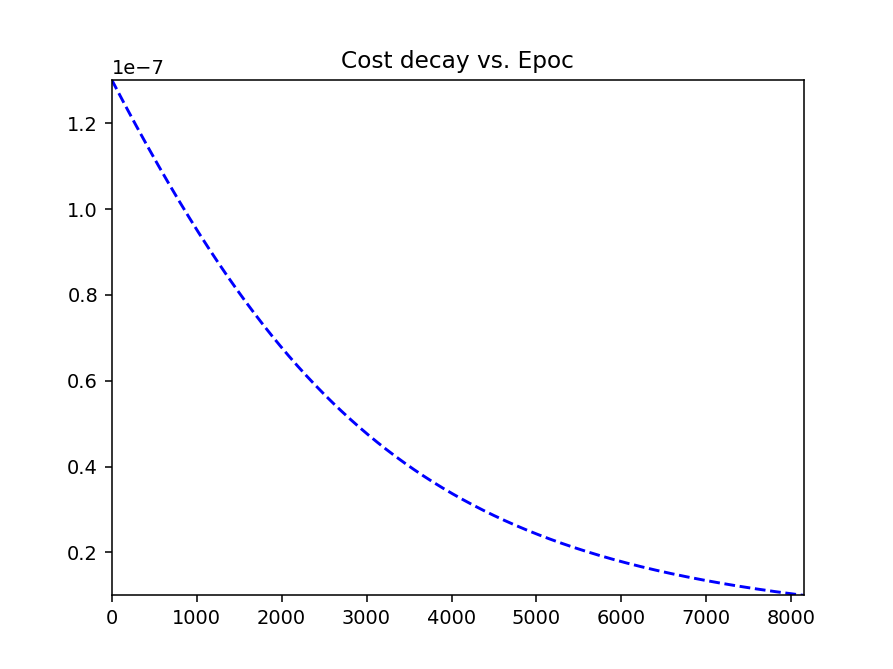

In [113]:
plt.figure()
plt.title("Cost decay vs. Epoc")
x = np.arange(0, len(conv_hist))
plt.axis([0, len(x), np.min(conv_hist), np.max(conv_hist)])

plt.plot(x, conv_hist, "b--")

plt.show()